# Seurat Analysis of Exp17.3-3

This is reanalysis using resequenced transcriptome library.

- Sample 1: LIF+2i+ \
total read count: 69,435,176 \
number of cells analysed: 2564 (before filtering) \
average reads per cell: 2899


- Sample 2: LIF-2i- \
total read count: 75,656,432 \
number of cells analysed: 7004 (before filtering) \
average reads per cell: 1690

In [1]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(patchwork)
library(tidyverse)
library(Matrix)
library(gghighlight)


 次のパッケージを付け加えます: ‘dplyr’ 


 以下のオブジェクトは ‘package:stats’ からマスクされています: 

     filter, lag 


 以下のオブジェクトは ‘package:base’ からマスクされています: 

     intersect, setdiff, setequal, union 


Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


 次のパッケージを付け加えます: ‘Matrix’ 


 以下のオブジェクトは ‘package:tidyr’ からマスクされています: 

     expand, pack, unpack 




In [2]:
#create object
s1.data <- read.table("/home/ha5666/DryLab/Projects/scCloneSelect/scCSExp17.3-3/061622_Hiseq_Dropseq/sample1/scCSExp17.3-3_sample1.txt.gz", sep = '\t', row.names = 1, header=T)
s2.data <- read.table("/home/ha5666/DryLab/Projects/scCloneSelect/scCSExp17.3-3/061622_Hiseq_Dropseq/sample2/scCSExp17.3-3_sample2.txt.gz", sep = '\t', row.names = 1, header=T)

projectname = "scCloneSelectExp17.3"

sample1 <- CreateSeuratObject(counts=s1.data, project=projectname)
sample2 <- CreateSeuratObject(counts=s2.data, project=projectname)

#add sample type as meta data
sample1[["sampletype"]]<- "LIF+2i+"
sample2[["sampletype"]]<- "LIF-2i-"

#percentage of reads that map to the mitochondrial genome
sample1[["percent.mt"]] <- PercentageFeatureSet(sample1, pattern="mt-")
sample2[["percent.mt"]] <- PercentageFeatureSet(sample2, pattern="mt-")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [3]:
# number of genes and single cells
dim(sample1)
dim(sample2)

[1] 18617  2564

[1] 20349  7004

In [4]:
# summary of total expression per single cell
summary(colSums(sample1))
summary(colSums(sample2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1290    1572    2899    2450   34606 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1075    1281    1690    1700   27113 

In [5]:
#merge samples
samplemerged <- merge(sample1, y = sample2, project = "scCSExp17.3-3")

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [4]:
samplemerged <- subset(samplemerged, subset = nFeature_RNA > 500 & percent.mt < 5)
samplemerged

An object of class Seurat 
38532 features across 9499 samples within 2 assays 
Active assay: SCT (16437 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

#standard workflow
samplemerged <- NormalizeData(object = samplemerged)
samplemerged <- FindVariableFeatures(object = samplemerged)
samplemerged <- ScaleData(object = samplemerged)
samplemerged <- RunPCA(object = samplemerged)
samplemerged <- FindNeighbors(object = samplemerged)
samplemerged <- FindClusters(object = samplemerged)
samplemerged <- RunTSNE(object = samplemerged)

In [5]:
samplemerged <- SCTransform(samplemerged, vars.to.regress = "percent.mt", verbose = FALSE)
samplemerged <- RunPCA(samplemerged, verbose = FALSE)
samplemerged <- RunUMAP(samplemerged, dims = 1:10, verbose = FALSE)
samplemerged <- FindNeighbors(samplemerged, dims = 1:10, verbose = FALSE)
samplemerged <- FindClusters(samplemerged, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [6]:
saveRDS(samplemerged,file="17.3-3.merged.data.mES.rds")

In [7]:
#samplemerged = readRDS("17.3-3.merged.data.mES.rds")

# find markers for every cluster compared to all remaining cells 

In [8]:
Idents(samplemerged) <- "sampletype"

samplemerged.markers <- FindAllMarkers(samplemerged, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

top10 <- samplemerged.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster LIF+2i+

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster LIF-2i-



Warning message in DoHeatmap(samplemerged, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: mm10-Pkm, mm10-Eno1, mm10-Mif”


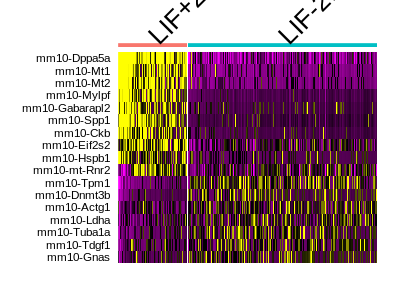

In [9]:
# find markers for every cluster compared to all remaining cells

w = 3
h = 2.7

heatmapcluster <- DoHeatmap(samplemerged, features = top10$gene) +
  theme(
    axis.title = element_text(size = FONT.SIZE),
    axis.text = element_text(colour = "black", size = FONT.SIZE),
    legend.position="none", 
    axis.text.y=element_text(size = 7, family="Helvetica"))

ggsave(file = "heatmapcluster.pdf", plot = heatmapcluster, width = w, height = h)

heatmapcluster